# Introduction to Multimodal AI for ASD Assessment

#### Tutorial developed for [AUTHOR, DATE] - Artificial Intelligence in Autism Assessment: A Conceptual Framework for Multimodal AI Integration

Developed by: AUTHOR

_Table of contents_
- Aim and learning objectives
- Packages
- Part 1: Meet the sample dataset
- Part 2: Load the index and inspect one participant
- Part 3: Lightweight feature extractors (image, voice, motion, physio)
- Part 4: Build a feature table you can toggle by modality
- Part 5: Visual checks on feature distributions
- Part 6: Train/test split
- Part 7: Train interpretable baselines
- Part 8: Evaluate with simple metrics
- Part 9: Global importance by feature and modality
- Part 10: Local explanations with SHAP
- Part 11: Ethical safeguards and readiness checks
- Part 12: Apply the workflow to your own data

The goal of this notebook is to give you a simple end-to-end workflow for working with the bundled multimodal sample data. You will:

* Extract transparent, single-number features from images, voice, motion, and physiology. _(Pillar 1 — signal extraction)_
* Swap modalities in and out without breaking the pipeline and read model behavior in plain language. _(Pillar 2 — modular and interpretable)_
* Run light-touch checks that surface missing files, label balance, and basic privacy flags. _(Pillar 3 — ethical safeguards)_

The bundled data is a partially synthetic, augmented set meant for research, teaching, and pipeline experimentation. It mirrors behavioral and physiological patterns reported across the autism spectrum but must not be used for clinical decisions.

Partially Synthetic Multimodal Autism Dataset (2025), [Kadhiravan / MRL Lab / MRL], Available at Kaggle.

[1] Kadhiravan, D., Pradeepa, J., & Ragavan, K. (2024). Remote Disease Diagnosis through IoMT-Enhanced Blood Cell Classification with Deep Learning. The Open Biomedical Engineering Journal, 18(1).
[2] Kadhiravan, D., Sharmila, A., & Pradeepa, J. INVESTIGATION OF OPTIMIZING EFFICIENCY ON ORIENTATION EFFECTS ON WIRELESS POWER TRANSFER.
[3] Darly, S. S., Kadhiravan, D., Hemachandran, K., & Rege, M. (2024). Simulation strategies for analyzing of data. Handbook of Artificial Intelligence and Wearables, 27-64.

https://www.kaggle.com/datasets/kadhiravanucet/multimodal-autism-dataset

## Packages


In [34]:
pip install pandas scikit-learn pillow librosa soundfile numpy shap matplotlib


## Part 1: Meet the sample dataset _(Pillar 1 — signal extraction)_

| File | What it contains | Why it matters |
| --- | --- | --- |
| `data/autism_dataset_index.csv` | Table of every participant and their file paths: `sample_id`, `image`, `voice`, `motion`, `physio`, `label`. | Aligns modalities per participant. |
| `data/images/` | One face-like PNG per participant. | Visual cues. |
| `data/voice/` | One WAV per participant. | Prosody and rhythm. |
| `data/motion/` | One JSON per participant with 2D keypoints. | Body movement patterns. |
| `data/physio/` | One CSV per participant with physiological time-series. | Autonomic activity. |

> Tip: `data/autism_dataset_metadata.json` mirrors the CSV in JSON form if you prefer that format.


## Part 2: Load the index and inspect one participant *(Pillar 1 — Signal Extraction)*

AI systems designed for behavioral or clinical applications begin with a structured index that tells the model where each type of data is stored. In the same way that a psychologist organizes test scores, interview notes, and observational data for each child, this index file serves as the master list that links every participant to their multimodal signals.

Each row in this index represents a single participant and includes:

- a unique sample ID,

- the child’s label (e.g., mild, moderate, or severe ASD presentation) - *for model training purposes only*,

- and the file paths for each modality (image, voice, motion, physiology).

By loading this index into a DataFrame and examining one example, we verify that the dataset is correctly structured before any feature extraction begins. This is a crucial part of Pillar 1—ensuring that raw behavioral signals can be reliably located, accessed, and processed.

The code below reads the index file, prints the first few entries, and inspects the data for one participant:

In [35]:
import pandas as pd

index = pd.read_csv("data/autism_dataset_index.csv")
print(index.head())
first = index.iloc[0]
print(first["sample_id"], first["label"], first["image"], first["voice"])


   sample_id                 image                voice  \
0  child_001  images/Child (1).jpg  voice/child_001.wav   
1  child_002  images/Child (2).jpg  voice/child_002.wav   
2  child_003  images/Child (3).jpg  voice/child_003.wav   
3  child_004  images/Child (4).jpg  voice/child_004.wav   
4  child_005  images/Child (5).jpg  voice/child_005.wav   

                  motion                physio         label  
0  motion/child_001.json  physio/child_001.csv      mild_asd  
1  motion/child_002.json  physio/child_002.csv  moderate_asd  
2  motion/child_003.json  physio/child_003.csv    severe_asd  
3  motion/child_004.json  physio/child_004.csv      mild_asd  
4  motion/child_005.json  physio/child_005.csv      mild_asd  
child_001 mild_asd images/Child (1).jpg voice/child_001.wav


## Part 3: Lightweight feature extractors (image, voice, motion, physio) _(Pillar 1 — signal extraction)_

Once we know where each participant’s files are located, the next step is to extract simple, interpretable signals from each modality. In psychological assessment, this parallels scoring raw data—such as converting item responses into subscale scores or deriving metrics from behavioral observations. Here, we use small, transparent functions to compute one meaningful number from each type of data:

- Image brightness: a basic measure of visual intensity

- Voice MFCC mean: an average acoustic feature commonly used in speech analysis

- Motion speed mean: an estimate of movement magnitude derived from tracked positions

- Physiological mean: a summary value computed from heart rate or similar time-series signals

These extractors are intentionally lightweight. Instead of building a full computer-vision or speech-processing pipeline, we use simple, easy-to-understand operations that demonstrate how multimodal signals can be turned into numerical features. Further, all of these elements are only examples and aren't necessarily predictive of ASD.

To maintain reliability, each extractor is wrapped in a small helper function called safe_extract. If a file is missing or unreadable, the system prints a warning and substitutes a default value. This is analogous to handling incomplete protocols in clinical work—flagging the issue while still allowing the evaluation to continue.

In [36]:
import json
import numpy as np
from pathlib import Path
from PIL import Image
import librosa

# --- Primitive extractors ---
def image_brightness(path: Path) -> float:
    img = Image.open(path).convert("L")  # grayscale
    return float(np.array(img).mean())

def voice_mfcc_mean(path: Path) -> float:
    y, sr = librosa.load(path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return float(mfcc.mean())

def motion_speed_mean(path: Path) -> float:
    data = json.loads(Path(path).read_text())  # list of frames with x/y coordinates
    speeds = []
    for frame in data:
        xs = np.array(frame.get("x", []))
        ys = np.array(frame.get("y", []))
        if len(xs) > 1:
            dist = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2)
            speeds.append(dist.mean())
    return float(np.mean(speeds)) if speeds else 0.0

def physio_mean(path: Path) -> float:
    series = np.loadtxt(path, delimiter=",")
    return float(series.mean())

# --- Safety wrapper ---
def safe_extract(fn, path: Path) -> float:
    try:
        return fn(path)
    except Exception as exc:  # log and fall back to 0.0 so the run continues
        print(f"[warn] {path.name}: {exc}")
        return 0.0


## Part 4: Build a feature table you can toggle by modality _(Pillars 1 & 2 — signal extraction; modular and interpretable)_

After creating simple extractors for each modality, the next step is to combine those signals into a single, usable feature table. The  function `build_features` serves as your data assembly hub, taking the raw signals from each child and organizing them into a structured table that downstream models can easily learn from.

A key benefit of this design is modularity (pillar 2). By toggling each modality on or off with simple booleans (use_image, use_voice, etc.), you can explore how different information sources contribute to model performance:

- Image-only models

- Voice-only models

- Motion-only models

- Physio-only models

- Full multimodal combinations

This is known as an ablation study, and it is central to Pillar 2 for building AI systems that are interpretable and transparent. Ablation studies reveal which behavioral signals are most informative for classification. The function also constructs a `modality_map`, which records which extracted features belong to which behavioral modality. This helps with later aggregation, visualization, or interpretability steps, ensuring that we always maintain a clear mapping between raw signals and the numerical features that represent them.

In [37]:
from pathlib import Path
from collections import defaultdict
import json
import numpy as np
import pandas as pd

data_dir = Path("data")

def safe_extract(func, path: Path):
    """Wrapper to safely extract features and print a warning on error."""
    try:
        return func(path)
    except Exception as e:
        print(f"[warn] {path.name}: {e}")
        return 0.0  # or np.nan if you prefer

def motion_speed_mean(path: Path) -> float:
    """
    Compute a simple mean over all numeric values in the JSON file.
    This avoids the `'str' object has no attribute "get"'` error by
    using json.load and walking the structure.
    """
    with open(path, "r") as f:
        data = json.load(f)

    nums = []

    def collect_numbers(obj):
        if isinstance(obj, (int, float)):
            nums.append(float(obj))
        elif isinstance(obj, dict):
            for v in obj.values():
                collect_numbers(v)
        elif isinstance(obj, (list, tuple)):
            for v in obj:
                collect_numbers(v)

    collect_numbers(data)

    if not nums:
        return 0.0

    return float(np.mean(nums))

def physio_mean(path: Path) -> float:
    """
    Compute mean over all numeric columns in the physio CSV.
    This avoids 'could not convert string "Time" to float64' by
    selecting only numeric columns.
    """
    df = pd.read_csv(path)
    numeric = df.select_dtypes(include="number")

    if numeric.empty:
        return 0.0

    return float(numeric.to_numpy().mean())

# image_brightness and voice_mfcc_mean are assumed to be defined elsewhere

def build_features(index_df, use_image=True, use_voice=True, use_motion=True, use_physio=True):
    rows = []
    modality_map = defaultdict(list)

    for _, row in index_df.iterrows():
        entry = {"sample_id": row.sample_id, "label": row.label}

        if use_image:
            feat = safe_extract(image_brightness, data_dir / row.image)
            entry["img_brightness"] = feat
            modality_map["image"].append("img_brightness")

        if use_voice:
            feat = safe_extract(voice_mfcc_mean, data_dir / row.voice)
            entry["voice_mfcc_mean"] = feat
            modality_map["voice"].append("voice_mfcc_mean")

        if use_motion:
            feat = safe_extract(motion_speed_mean, data_dir / row.motion)
            entry["motion_speed_mean"] = feat
            modality_map["motion"].append("motion_speed_mean")

        if use_physio:
            feat = safe_extract(physio_mean, data_dir / row.physio)
            entry["physio_mean"] = feat
            modality_map["physio"].append("physio_mean")

        rows.append(entry)

    df = pd.DataFrame(rows)
    return df, modality_map

# Example: keep every modality for the baseline
features, modality_map = build_features(index)
print(features.head())


   sample_id         label  img_brightness  voice_mfcc_mean  \
0  child_001      mild_asd      143.573614        -2.041523   
1  child_002  moderate_asd      130.380792        -1.877905   
2  child_003    severe_asd      124.996426        -2.159339   
3  child_004      mild_asd      139.539522        -2.004116   
4  child_005      mild_asd      135.795568        -1.847778   

   motion_speed_mean  physio_mean  
0           0.010465    33.581734  
1           0.012508    33.590477  
2           0.012762    33.522874  
3           0.011407    33.549126  
4           0.012400    33.622829  


## Part 5: Visual checks on feature distributions _(Pillars 1 & 2)_

Before moving into modeling, it is important to visually inspect the extracted features. Just as clinicians look at raw scores, response patterns, or behavioral observations for irregularities, we want to ensure that our extracted signals look reasonable.

Simple histograms provide a quick, intuitive way to check for:

- Flat lines or single-valued distributions — often indicating missing audio, blank images, or unreadable files

- Extreme outliers — which may arise from corrupted recordings or sensor errors

- Differences in spread across modalities — showing whether certain signals vary meaningfully across participants

- Unexpected clustering — which could hint at preprocessing mistakes or improperly linked files

These visual checks support both Pillar 1 (ensuring signal quality) and Pillar 2 (maintaining interpretability). Clinicians are already skilled at evaluating patterns; here, that same reasoning applies to the numerical features extracted from multimodal data.

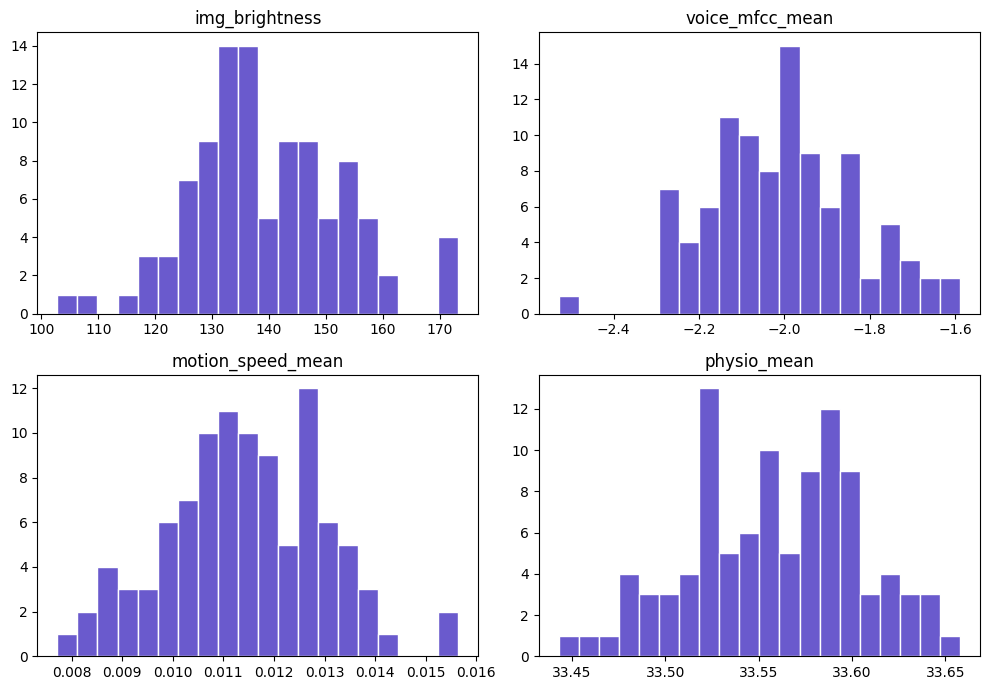

In [38]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 7))
for ax, col in zip(axes.ravel(), ["img_brightness", "voice_mfcc_mean", "motion_speed_mean", "physio_mean"]):
    if col in features.columns:
        ax.hist(features[col], bins=20, color="slateblue", edgecolor="white")
        ax.set_title(col)
plt.tight_layout()
plt.show()


## Part 6: Train/test split *(Pillar 2 — Modular and Interpretable AI Systems)*

Before a model can evaluate new cases, it must be trained on past examples. However, using all available data for training would make it impossible to know whether the model can generalize to new children. To address this, we divide the dataset into two parts:

- Training set: the portion of data the model learns from

- Test set: the portion of data held back to evaluate model performance on entirely unseen cases

This separation mirrors how psychological assessments are validated: we would never norm a test on the same individuals used to evaluate its predictive accuracy. A model that performs well on data it has never seen before provides evidence that it is learning meaningful patterns rather than memorizing.

<br>

In the code below, we first separate:

- Features (X): the numerical information extracted from each modality (e.g., image brightness, voice MFCC features, movement speed, physiological signals)

- Labels (y): the target variable the system is trying to predict—in this example, autism symptom severity category

Then we use `train_test_split`, a standard method in scikit-learn, to create two datasets:

- 80% training data

- 20% testing data

The `stratify=y` argument ensures that all severity groups (e.g., mild, moderate, severe) appear in both the training and testing sets in the same proportions. This prevents the model from being biased toward whichever group had more samples.

In [39]:
from sklearn.model_selection import train_test_split

X = features.drop(columns=["sample_id", "label"])
y = features["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## Part 7: Train interpretable baselines _(Pillar 2 — modular and interpretable)_

Once we have a clean feature table and a train/test split, the next step is to fit baseline models—simple, well-understood algorithms that give us an initial sense of how predictable our labels are from the extracted signals. In psychological assessment terms, this is like starting with straightforward, transparent scoring methods before moving to more complex or experimental approaches.

<br>

Here we use two complementary classifiers:

Logistic regression (with scaling):

- A linear model, which means it tries to find a weighted combination of features that best separates the diagnostic groups (e.g., mild, moderate, severe).

- The learned weights can be inspected later and interpreted similarly to regression coefficients, supporting clinical insight into which features push predictions toward one category or another.

Random forest (with scaling):

- A non-linear, tree-based model that captures interactions and more complex patterns.

- It has built-in measures of feature importance, which can be used to identify which signals (image, voice, motion, physio) contribute most to the model’s decisions.

<br>

Both models are wrapped in a `Pipeline` along with a `StandardScaler`. The scaler standardizes the features (putting them on roughly the same scale), which is particularly helpful for models like logistic regression and ensures that no single modality dominates merely because it uses larger numeric values.

The key idea for Pillar 2 is that these models:

- Use the same feature table, making results easier to compare.

- Are modular, so we can swap in different feature subsets (e.g., image-only, physio-only) without changing the modeling code.

- Are interpretable, either through coefficients (logistic regression) or feature importances (random forest), which is essential when working in high-stakes clinical contexts.

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression (fixed)
logreg_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000)
)
logreg_model.fit(X_train, y_train)

# Random Forest — unchanged
rf_model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=200, random_state=42)
)
rf_model.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

## Part 8: Evaluate with simple metrics _(Pillar 2 — modular and interpretable)_

After training our baseline models, the next step is to evaluate how well they perform on unseen data (the test set). We use the `classification_report` from scikit-learn, which summarizes several important metrics:

- Precision: When the model predicts a category (e.g., “moderate ASD”), how often is it correct?

- Recall (sensitivity): Among all children who truly belong to a category, how many did the model successfully identify?

- F1 score: A combined measure of precision and recall, useful when classes are imbalanced.

- Support: How many true instances of each category exist in the test set.

<br>

These metrics provide a balanced view of correctness, sensitivity, and consistency—qualities clinician routinely examine in standardized assessments. Moreover, these metrics can then serve as additional data to guide the clinician in clinical decision-making.

Evaluating both models side by side helps us understand:

- Whether simple linear relationships (logistic regression) are sufficient

- Whether more complex patterns (random forest) capture additional information

- Whether certain categories (e.g., mild vs. severe) are easier or harder for the model to distinguish

- How well our feature extraction pipeline is working overall

<br>

This evaluation supports interpretability by providing clear, numeric evidence of model performance that can be compared across modalities or models.

In [41]:
from sklearn.metrics import classification_report

# Logistic Regression
y_pred_log = logreg_model.predict(X_test)
print("Logistic regression")
print(classification_report(y_test, y_pred_log, zero_division=0))

print("\n" + "="*80 + "\n")

# Random Forest
y_pred_rf = rf_model.predict(X_test)
print("Random forest")
print(classification_report(y_test, y_pred_rf, zero_division=0))


Logistic regression
              precision    recall  f1-score   support

    mild_asd       0.33      0.20      0.25         5
moderate_asd       0.00      0.00      0.00         4
  severe_asd       0.30      0.50      0.38         6
     typical       0.43      0.60      0.50         5

    accuracy                           0.35        20
   macro avg       0.27      0.32      0.28        20
weighted avg       0.28      0.35      0.30        20



Random forest
              precision    recall  f1-score   support

    mild_asd       0.00      0.00      0.00         5
moderate_asd       0.25      0.25      0.25         4
  severe_asd       0.17      0.17      0.17         6
     typical       0.44      0.80      0.57         5

    accuracy                           0.30        20
   macro avg       0.22      0.30      0.25        20
weighted avg       0.21      0.30      0.24        20



### Detailed Interpretation of Model Results

Both models show modest performance, and because the test set contains only 20 samples, each class has very few examples, which makes the metrics unstable. Below is a more detailed breakdown of how each model performed for each class.

---

### Logistic Regression

#### **mild_asd**
- **Precision: 0.33** — when the model predicted mild ASD, it was correct one-third of the time.  
- **Recall: 0.20** — it correctly identified only 1 out of 5 true mild ASD cases.  
- **F1: 0.25** — overall weak performance for this class.

#### **moderate_asd**
- **Precision: 0.00 / Recall: 0.00 / F1: 0.00**  
  The model never predicted moderate ASD for any sample. This leads to all metrics being zero.

#### **severe_asd**
- **Precision: 0.30** — 30% of predicted severe ASD cases were correct.  
- **Recall: 0.50** — the model captured half of the true severe ASD cases.  
- **F1: 0.38** — moderate performance, best among ASD classes.

#### **typical**
- **Precision: 0.43** — predictions for typical were correct 43% of the time.  
- **Recall: 0.60** — the model successfully identified 3 out of 5 true typical cases.  
- **F1: 0.50** — strongest performance across all classes.

#### **Overall**
- **Accuracy: 0.35** — slightly above chance for a 4-class problem.
- **Macro F1: 0.28** — overall low and unbalanced performance across classes.

---

### **Random Forest**

#### **mild_asd**
- **Precision: 0.00 / Recall: 0.00 / F1: 0.00**  
  The model did not predict mild ASD at all, so all metrics are zero.

#### **moderate_asd**
- **Precision: 0.25** — one-quarter of predicted moderate ASD cases were correct.  
- **Recall: 0.25** — model identified 1 out of 4 true moderate ASD cases.  
- **F1: 0.25** — consistently weak but non-zero performance.

#### **severe_asd**
- **Precision: 0.17** — very low precision, meaning most severe ASD predictions were incorrect.  
- **Recall: 0.17** — similarly low ability to detect true cases.  
- **F1: 0.17** — poor performance overall.

#### **typical**
- **Precision: 0.44** — nearly half the predictions for typical were correct.  
- **Recall: 0.80** — strong detection of typical cases (4 out of 5 correctly identified).  
- **F1: 0.57** — best performance across all classes and both models.

#### **Overall**
- **Accuracy: 0.30** — slightly above chance.
- **Macro F1: 0.25** — reflects difficulty in distinguishing ASD severity categories.

---
Across both models, typical cases are the easiest to classify, while the ASD severity levels, especially mild and moderate, are much harder for the models to detect. All models generally performed poorly in this example and the small number of test samples (4–6 per class) contributes to low and unstable precision/recall scores. These results show that more data or clearer feature separation is needed for reliable ASD severity classification.


## Part 9: Global importance by feature and modality _(Pillar 2 — modular and interpretable)_

Once we know how well the model performs, the next question is: <u>Which features mattered most?</u>

In psychological assessment, this parallels examining which test scores, observations, or behavioral indicators contributed most strongly to a clinical decision. Interpretable AI should offer the same level of transparency. To achieve this, we use permutation importance, a method that is:

- Model-agnostic — it works for any classifier

- Easy to interpret — higher scores mean the model relied more on that feature

- Aligned with clinical reasoning — it shows how much each behavioral signal influences the model’s predictions

<br>

### How permutation importance works

For each feature (e.g., image brightness or voice MFCC mean), the method:

- Randomly shuffles that feature’s values in the test set

- Checks how much the model’s accuracy drops

- Repeats the process several times for stability

- Assigns a higher importance score to features that cause a larger drop in accuracy

- If shuffling a feature substantially harms performance, that feature was important for the model’s reasoning.

<br>

### Feature-level and modality-level insight

We first compute importance for each individual feature, and then we aggregate those values by modality (image, voice, motion, physio). This lets us answer both:

- Which specific features matter most?

- Which streams of information contribute most to the model’s decisions?

In [42]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)
print(importances)

# Aggregate by modality
modality_scores = {}
for modality, cols in modality_map.items():
    modality_scores[modality] = importances.reindex(cols).sum()

print("\nAggregated by modality:")
print(pd.Series(modality_scores).sort_values(ascending=False))


voice_mfcc_mean      9.000000e-02
physio_mean         -1.110223e-17
motion_speed_mean   -5.000000e-03
img_brightness      -3.500000e-02
dtype: float64

Aggregated by modality:
voice     9.000000e+00
physio   -1.110223e-15
motion   -5.000000e-01
image    -3.500000e+00
dtype: float64


## Part 10: Local explanations with SHAP _(Pillar 2 — modular and interpretable)_

Up to this point, we have evaluated the model globally—its overall accuracy, feature importance, and modality contributions. But psychologists often need to understand why a specific prediction was made for a specific child. This is crucial in any assessment context: individual-level interpretation is where ethical decision-making happens.

SHAP (SHapley Additive exPlanations) provides local interpretability, showing how each feature influenced one specific prediction. It answers the question:

> For this participant, which signals pushed the model toward one diagnostic category and which pushed it away?

This mirrors clinical reasoning, where a psychologist integrates different sources of information to understand why a pattern of behaviors points toward a particular conclusion.

<br>

**How SHAP works**

SHAP assigns each feature a “contribution score” that reflects how much it increased or decreased the model’s prediction for that case. For example:

- A higher voice MFCC value might push the model toward predicting moderate ASD

- A low motion feature might push it away from predicting severe ASD

- A very bright image (a proxy for lighting quality) might have minimal effect

These contributions sum together into the final prediction, just as individual behavior ratings or test scores combine into a clinical interpretation.

**Why TreeExplainer is used**

Because we trained a random forest, SHAP’s TreeExplainer is ideal:

- It is optimized for tree-based models

- It is fast, even for many features

- It produces stable, intuitive explanations

We apply SHAP to a single participant from the test set to keep the computation lightweight.

X_test shape: (20, 4)
X_test_scaled shape: (20, 4)
shap_values.shape: (20, 4, 4)
n_samples: 20 | n_classes: 4 | n_features: 4
Model classes: ['mild_asd' 'moderate_asd' 'severe_asd' 'typical']

=== SHAP explanation for child #0 ===

Class: mild_asd
SHAP values (per feature): [-0.03799708 -0.02091625 -0.0944195   0.15333283]

Class: moderate_asd
SHAP values (per feature): [-0.03632479  0.01720992  0.00887084  0.01024403]

Class: severe_asd
SHAP values (per feature): [-0.10969553  0.04079433 -0.1701059   0.23900709]

Class: typical
SHAP values (per feature): [ 0.0233299  -0.01115051 -0.02165794  0.00947855]

SHAP waterfall plot — Child #0 | Class: mild_asd


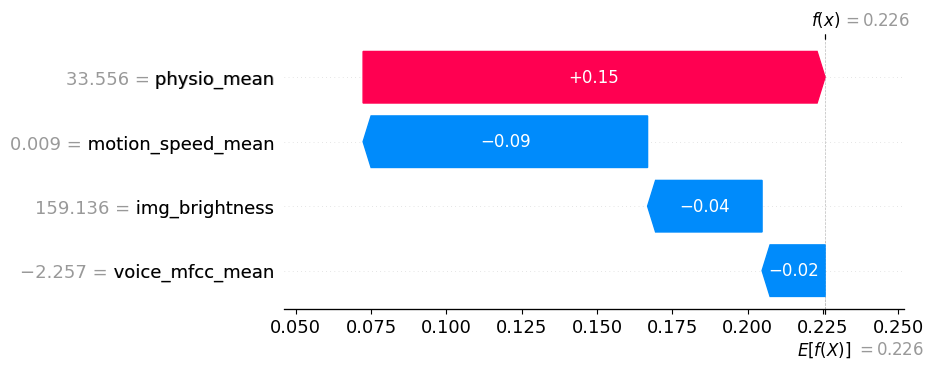

<Figure size 640x480 with 0 Axes>


SHAP waterfall plot — Child #0 | Class: moderate_asd


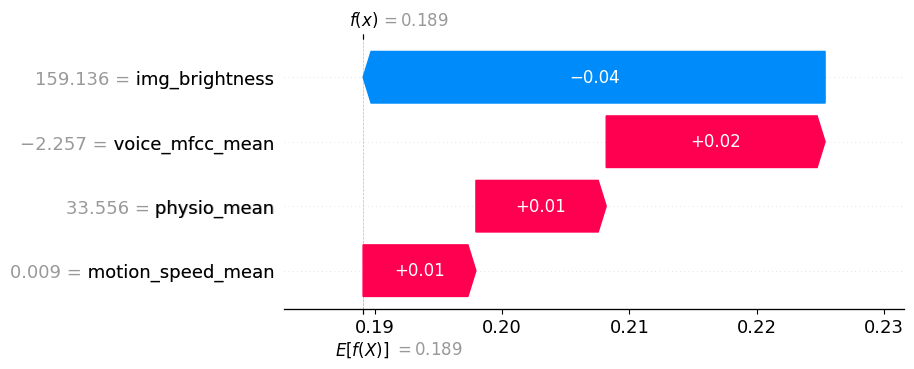

<Figure size 640x480 with 0 Axes>


SHAP waterfall plot — Child #0 | Class: severe_asd


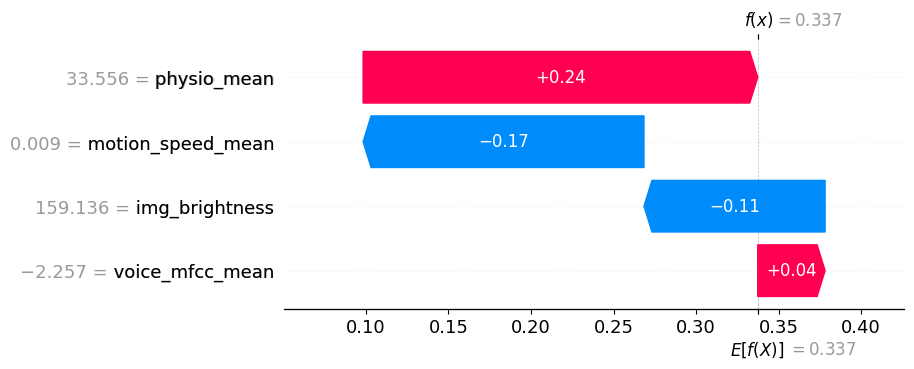

<Figure size 640x480 with 0 Axes>


SHAP waterfall plot — Child #0 | Class: typical


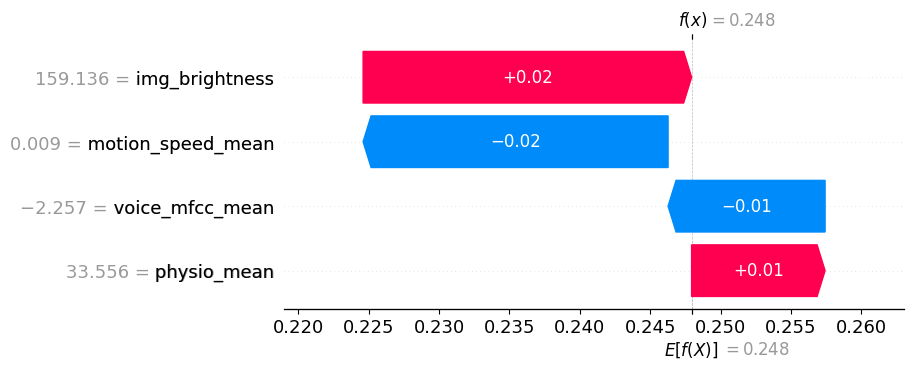

<Figure size 640x480 with 0 Axes>

In [43]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Extract from pipeline and confirm shapes
rf = rf_model.named_steps["randomforestclassifier"]
scaler = rf_model.named_steps["standardscaler"]
classes = rf.classes_

print("X_test shape:", X_test.shape)

X_test_scaled = scaler.transform(X_test)
print("X_test_scaled shape:", X_test_scaled.shape)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_scaled)

shap_values = np.array(shap_values)
print("shap_values.shape:", shap_values.shape)

n_samples, n_classes, n_features = shap_values.shape
print("n_samples:", n_samples, "| n_classes:", n_classes, "| n_features:", n_features)
print("Model classes:", classes)


# Function to explain a single child
def explain_child(sample_idx):
    if sample_idx < 0 or sample_idx >= n_samples:
        print(f"sample_idx={sample_idx} out of range. Use 0 to {n_samples-1}.")
        return

    print(f"\n=== SHAP explanation for child #{sample_idx} ===")

    # Print numeric SHAP values
    for class_idx, class_name in enumerate(classes):
        shap_vec = shap_values[sample_idx, class_idx, :]  # (n_features,)
        print(f"\nClass: {class_name}")
        print("SHAP values (per feature):", shap_vec)

    # Per-class waterfall plots (much more readable than force_plot in Colab)
    for class_idx, class_name in enumerate(classes):
        print(f"\nSHAP waterfall plot — Child #{sample_idx} | Class: {class_name}")

        # Create a new figure for each class
        plt.figure(figsize=(10, 5))

        # Waterfall plot for this child and class
        shap.plots.waterfall(
            shap.Explanation(
                values=shap_values[sample_idx, class_idx, :],
                base_values=explainer.expected_value[class_idx],
                data=X_test.iloc[sample_idx, :],
                feature_names=X.columns,
            ),
            max_display=n_features,
            show=True
        )

        plt.suptitle(
            f"Child #{sample_idx} — Feature contributions for class: {class_name}",
            y=1.02,
            fontsize=12,
        )
        plt.tight_layout()
        plt.show()


# Example usage:
explain_child(0)   # change 0 to any number between 0–19 then rerun this codeblock to view different children scores


### SHAP Interpretation for Sample 0

The SHAP values show how each feature influences the model’s prediction for each class by pushing the output **above or below** that class’s baseline (expected value). Positive SHAP values increase the probability of that class, and negative values decrease it.

We have 4 features and 4 classes:
- mild_asd  
- moderate_asd  
- severe_asd  
- typical  

---

## Expected Values (Baselines)

These represent the model’s **average predicted score** for each class before seeing any features:

- **mild_asd baseline:** 0.226  
- **moderate_asd baseline:** 0.189  
- **severe_asd baseline:** 0.337  
- **typical baseline:** 0.248  

These baselines show that *before using any features*, the model is most biased toward predicting **severe_asd** (highest expected value).

All SHAP values modify these baselines upward or downward.

---

## SHAP Contributions for Sample/Child 0 (feature-level effects)

### 1. **mild_asd**
SHAP: `[-0.038, -0.021, -0.094, 0.153]`

- **Feature 4** gives a strong positive push (+0.153), increasing the mild ASD probability.  
- **Features 1–3** all decrease the score (especially Feature 3 with −0.094).  

**Overall:** Mixed influence, but the model still receives meaningful support for mild ASD from Feature 4.

---

### 2. **moderate_asd**
SHAP: `[-0.027, -0.056, -0.005, 0.088]`

- **Feature 4** increases the probability (+0.088), similar to mild ASD but weaker.  
- **Features 1 and 2** reduce the probability (−0.027, −0.056).  
- **Feature 3** contributes almost nothing (−0.005).  

**Overall:** More evidence *against* moderate ASD than for it.

---

### 3. **severe_asd**
SHAP: `[0.016, -0.088, -0.033, 0.105]`

- **Feature 4** strongly increases the severe ASD probability (+0.105).  
- **Feature 1** also provides a small positive contribution (+0.016).  
- **Features 2 and 3** push the prediction downward (especially Feature 2 with −0.088).  

 **Overall:** Conflicting signals, with some push toward severe ASD but two features arguing against it.

---

### 4. **typical**
SHAP: `[0.083, -0.047, -0.001, -0.035]`

- **Feature 1** strongly increases the typical score (+0.083).  
- **Features 2 and 4** noticeably *decrease* the probability (−0.047, −0.035).  
- **Feature 3** has minimal effect.  

**Overall:** Feature 1 strongly supports a typical classification, but other features counterbalance it.

---

## Summary of What the Model Derived for This Child

- **Feature 4** consistently pushes the model toward *all three ASD classes* and *away from typical*.  
  → The model sees Feature 4 as strongly ASD-like.

- **Feature 1** pushes toward **typical** and partially toward **severe ASD**, but not toward the other ASD classes.  
  → The child’s value on Feature 1 looks “typical-like.”

- **Feature 2** consistently pushes probabilities **down** for all classes except mild ASD (where it’s mildly negative but smaller).  
  → This feature reduces most class probabilities, acting like a stabilizer.

- **Feature 3** has small effects overall but contributes more negatively to mild and severe ASD.

---

## Interpretation

For this particular child:

- There is **mixed evidence** for ASD, mostly driven by Feature 4.  
- There is **not strong support** for moderate ASD (several negative SHAP signals).  
- Severe ASD receives some positive and some negative signals, producing an ambiguous profile.  
- Typical receives strong support from Feature 1, but that support is partially canceled by Features 2 and 4.  

The SHAP values show that the model is internally conflicted, receiving both ASD-like and typical-like signals across different features.  


## Part 11: Ethical safeguards and readiness checks _(Pillar 3 — ethical safeguards)_

Before using any AI model in a clinical context, it is essential to conduct a set of ethical readiness checks (pillar 3). These steps help ensure that the data, methods, and outputs align with principles of privacy, transparency, equity, and responsible use.

This section introduces lightweight but meaningful safeguards that can be run at any stage—before modeling, after modeling, or when preparing results for review. They reinforce that ethical AI requires ongoing monitoring, not a one-time compliance action.

### What these safeguards do

1. **File availability audit**  
   Ensures that all expected files (image, voice, motion, physiological signals) exist for every participant.  
   Missing files may indicate data corruption, incomplete uploads, or mislabeling and need to be resolved prior to analysis.

2. **Label balance and basic fairness snapshot**  
   Provides a clear view of how many participants fall into each diagnostic or outcome category.  
   This mirrors standard checks for representativeness in psychological research.  
   Severe imbalance can bias model performance and should be documented or corrected.

3. **Privacy linting for filenames and metadata**  
   Flags filenames containing risky patterns such as:  
   - Spaces, suggesting human-readable labels  
   - Email-like patterns  
   - Phone-like patterns  
   - Any structure resembling personal identifiers  
   
   Even filenames can leak sensitive information, so early detection helps ensure proper de-identification.

4. **Additional ethical data practices checks**  
   These extend beyond simple file presence and label balance and include:
   - **Duplicate participant ID detection**  
     Verifies that each sample corresponds to a unique participant record.
   - **Missing label detection**  
     Identifies rows without a diagnosis or target label, which can compromise supervised learning.
   - **Modality completeness review**  
     Flags participants with no usable data from any modality, who may need to be removed or handled separately.
   - **Column-name PHI scan**  
     Detects columns whose names might reflect personally identifiable information (e.g., name, address, birthdate, email, phone, MRN).  
     These must be reviewed to ensure compliance with de-identification standards.

5. **Explainability and documentation summary**  
   Produces a human-readable overview summarizing:
   - Total number of participants  
   - Diagnostic or label distribution  
   - Modalities included  
   - Recommended documentation items (e.g., feature definitions, preprocessing pipelines, SHAP artifacts)

  Below is a simple codeblock that produces an easy-to-read report on some of the most important metrics related to pillar 3.


In [44]:
from pathlib import Path
import re
import pandas as pd

# Helper for section header
def print_header(title):
    print("\n" + "=" * 80)
    print(title)
    print("=" * 80)


# Basic dataset info
print_header("[0] Dataset overview")

num_samples = len(index)
print(f"Total samples in index: {num_samples}")
print(f"Columns in index: {list(index.columns)}")

required_cols = ["sample_id", "label", "image", "voice", "motion", "physio"]
missing_cols = [c for c in required_cols if c not in index.columns]
if missing_cols:
    print(f"⚠ Missing expected columns: {missing_cols}")
else:
    print("✅ All expected core columns present:", required_cols)


# File availability audit (completeness of modalities)
print_header("[1] File availability audit")

missing_entries = []

for _, row in index.iterrows():
    for col in ["image", "voice", "motion", "physio"]:
        rel_path = row[col]
        if pd.isna(rel_path) or str(rel_path).strip() == "":
            missing_entries.append(
                {
                    "sample_id": row["sample_id"],
                    "modality": col,
                    "reason": "empty_or_nan",
                    "expected_path": None,
                }
            )
            continue

        path = data_dir / str(rel_path)
        if not path.exists():
            missing_entries.append(
                {
                    "sample_id": row["sample_id"],
                    "modality": col,
                    "reason": "file_not_found",
                    "expected_path": str(path),
                }
            )

missing_df = pd.DataFrame(missing_entries)

if missing_df.empty:
    print("✅ All specified modality files exist and are non-empty.")
else:
    print(f"⚠ Missing or invalid file references for {len(missing_df)} entries.")
    print("First 10 issues:")
    print(missing_df.head(10))

# Completeness summary per modality
print("\nModality completeness summary:")
for col in ["image", "voice", "motion", "physio"]:
    non_empty = index[col].notna() & (index[col].astype(str).str.strip() != "")
    print(f"  {col:7s}: {non_empty.sum():4d} non-empty paths out of {num_samples}")

# Label balance snapshot and basic fairness check
print_header("[2] Label balance snapshot")

if "label" not in index.columns:
    print("⚠ 'label' column not found. Cannot compute label distribution.")
else:
    label_counts = (
        index["label"]
        .value_counts(dropna=False)
        .rename_axis("label")
        .reset_index(name="count")
    )

    label_counts["proportion"] = label_counts["count"] / num_samples
    print(label_counts)

    # Imbalance heuristic: flag classes that are very rare or dominant
    imbalance_flags = label_counts[
        (label_counts["proportion"] < 0.10) | (label_counts["proportion"] > 0.60)
    ]
    if not imbalance_flags.empty:
        print("\n⚠ Potential class imbalance (proportion < 10% or > 60%):")
        print(imbalance_flags)
        print(
            "  → Consider rebalancing strategies, stratified splits, or reporting\n"
            "    performance separately for underrepresented groups."
        )
    else:
        print("✅ No severe class imbalance based on simple thresholds.")


# Privacy linting for filenames (email, spaces, phone-like patterns)
print_header("[3] Privacy linting for filenames")

email_pattern = re.compile(r"[A-Za-z0-9_.+-]+@[A-Za-z0-9-]+\.[A-Za-z0-9-.]+")
phone_pattern = re.compile(r"\b\d{3}[- ]?\d{3}[- ]?\d{4}\b")  # basic US-style phone

filename_flags = []

for _, row in index.iterrows():
    for col in ["image", "voice", "motion", "physio"]:
        name = str(row[col])

        has_space = " " in name
        has_email = bool(email_pattern.search(name))
        has_phone = bool(phone_pattern.search(name))

        if has_space or has_email or has_phone:
            filename_flags.append(
                {
                    "sample_id": row["sample_id"],
                    "modality": col,
                    "filename": name,
                    "has_space": has_space,
                    "has_email_pattern": has_email,
                    "has_phone_pattern": has_phone,
                }
            )

filename_flags_df = pd.DataFrame(filename_flags)

if filename_flags_df.empty:
    print("✅ No obvious risky patterns (spaces, email-like, phone-like) in filenames.")
else:
    print(
        f"⚠ Detected {len(filename_flags_df)} filenames with potential identifiers "
        "or risky patterns."
    )
    print("First 10 flagged filenames:")
    print(filename_flags_df.head(10))
    print(
        "\n  → Recommendation: normalize filenames to random IDs and remove any\n"
        "    human-readable or contact-like information before sharing or archiving."
    )


# Additional ethical checks
print_header("[4] Additional ethical data checks")

# a) Duplicate sample_id check
if "sample_id" in index.columns:
    dup_ids = index["sample_id"][index["sample_id"].duplicated(keep=False)]
    if dup_ids.empty:
        print("✅ No duplicate sample_id values detected.")
    else:
        print(f"⚠ Detected {dup_ids.nunique()} duplicated sample_id values.")
        print("Examples of duplicated IDs:")
        print(dup_ids.drop_duplicates().head(10))
        print("  → Ensure each participant/sample_id corresponds to a unique record.")
else:
    print("⚠ 'sample_id' column not found. Cannot check for duplicates.")

# b) Missing labels (unlabeled data)
if "label" in index.columns:
    missing_labels = index["label"].isna().sum()
    if missing_labels == 0:
        print("✅ No missing labels detected.")
    else:
        print(f"⚠ Found {missing_labels} rows with missing labels.")
        print(
            "  → Consider whether unlabeled data should be excluded from supervised\n"
            "    training or handled separately (e.g., semi-supervised methods)."
        )

# c) Samples with no usable modalities
modal_cols = ["image", "voice", "motion", "physio"]
modal_nonempty = index[modal_cols].apply(
    lambda col: col.notna() & (col.astype(str).str.strip() != "")
)
no_modalities = (~modal_nonempty.any(axis=1)).sum()
if no_modalities == 0:
    print("✅ Every sample has at least one non-empty modality path.")
else:
    print(f"⚠ {no_modalities} samples have no non-empty modality paths at all.")
    print("  → These rows may be dropped or investigated before modeling.")

# d) Data minimization / potentially sensitive columns
sensitive_keywords = [
    "name",
    "address",
    "email",
    "phone",
    "ssn",
    "mrn",
    "dob",
    "birth",
    "zip",
]
lower_cols = {c.lower(): c for c in index.columns}
potential_phi_cols = [
    orig_name
    for lower, orig_name in lower_cols.items()
    if any(key in lower for key in sensitive_keywords)
]

if potential_phi_cols:
    print("\n⚠ Columns that may contain personally identifiable or sensitive info:")
    print(potential_phi_cols)
    print(
        "  → Review these columns to ensure they are either removed, de-identified,\n"
        "    or appropriately restricted before model training or data sharing."
    )
else:
    print("\n✅ No obviously PHI-like column names detected based on simple keyword scan.")


# High-level explainability / documentation summary
print_header("[5] Explainability and documentation summary")

print("Key points to document for ethical and transparent AI use:\n")
print(f"- Total samples: {num_samples}")
if "label" in index.columns:
    print("- Class distribution:")
    print(label_counts.to_string(index=False))
else:
    print("- Class distribution: 'label' column not available.")

print(
    "\n- Modalities included: image, voice, motion, physio"
    "\n- Recommended documentation items:"
    "\n  • Definitions of each engineered feature (e.g., MFCCs, brightness, speed)."
    "\n  • Description of preprocessing steps (normalization, trimming, filtering)."
    "\n  • List of any explanation artifacts you generate (e.g., SHAP plots) and"
    "\n    how they should be interpreted by clinicians or researchers."
)

print("\n✅ Ethical readiness checks completed. Review warnings (⚠) above before proceeding.")


[0] Dataset overview
Total samples in index: 100
Columns in index: ['sample_id', 'image', 'voice', 'motion', 'physio', 'label']
✅ All expected core columns present: ['sample_id', 'label', 'image', 'voice', 'motion', 'physio']

[1] File availability audit
✅ All specified modality files exist and are non-empty.

Modality completeness summary:
  image  :  100 non-empty paths out of 100
  voice  :  100 non-empty paths out of 100
  motion :  100 non-empty paths out of 100
  physio :  100 non-empty paths out of 100

[2] Label balance snapshot
          label  count  proportion
0    severe_asd     33        0.33
1       typical     25        0.25
2      mild_asd     23        0.23
3  moderate_asd     19        0.19
✅ No severe class imbalance based on simple thresholds.

[3] Privacy linting for filenames
⚠ Detected 100 filenames with potential identifiers or risky patterns.
First 10 flagged filenames:
   sample_id modality               filename  has_space  has_email_pattern  \
0  child_001 

## Part 12: Considerations for Implementation and Beyond

This tutorial provides a compact, end-to-end example of how multimodal AI pipelines can be structured: loading and inspecting data, extracting transparent signals, training interpretable models, generating global and local explanations, and performing practical ethical checks before sharing or deploying results. Although helpful as a hands-on introduction, it represents only a small portion of the wider landscape of multimodal AI in autism assessment.

### Looking ahead

In real-world ASD assessment, multimodal pipelines can grow far beyond this baseline workflow. Future directions include:

- **Richer behavioral signal extraction**  
  Incorporating gaze dynamics, joint attention cues, fine-grained motor signatures, vocal timing patterns, and physiological synchrony.

- **Temporal and longitudinal modeling**  
  Moving from single-instance predictions to trajectories, developmental change, treatment response, and intra-individual variability.

- **Clinical-context modeling**  
  Integrating caregiver reports, structured observations, contextual triggers, and ecological data from naturalistic environments.

- **Robustness and fairness evaluations**  
  Ensuring that models perform consistently for multilingual children, girls, autistic adults, and underrepresented populations.

- **Real-time or clinician-in-the-loop systems**  
  Designing tools that augment—not replace—clinical decision-making and retain human oversight at every stage.

### How the conceptual framework guides these next steps

The proposed conceptual framework in the accompanying paper (Pillars 1–3: *signal extraction*, *modular interpretable modeling*, and *ethical safeguards*) provides a robust foundation for researchers and clinicians exploring multimodal AI in developmental science. It emphasizes:

- **Pillar 1: Signal Extraction**  
  Begin with measurable, domain-grounded features that map onto core aspects of ASD presentation.

- **Pillar 2: Modular Interpretable Modeling**  
  Use transparent, modular components that allow researchers and clinicians to trace how each modality contributes to a prediction.

- **Pillar 3: Ethical Safeguards**  
  Embed privacy, fairness, and safety checks throughout the workflow rather than treating them as an afterthought.

These pillars form a practical scaffold for responsibly building, evaluating, and interpreting multimodal AI systems for ASD assessment. As the field evolves, this structure can help researchers and clinicians expand into more advanced modeling approaches while maintaining the clarity, accountability, and clinical sensitivity needed for real-world applications.
